In [2]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.regression.linear_model import OLS
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale

data=pd.read_csv("HW1.csv")

In [3]:
''' 아무것도 조작하지 않은 그냥 데이터'''
### dataset을 쪼개기 ###
data_new = data.iloc[:,1:]
train_X = np.array(scale(data_new.iloc[:,0:24])[0:20000])
train_Y1 = np.array(data_new['Y1'][0:20000])
train_Y2 = np.array(data_new['Y2'][0:20000]) 
test_X = np.array(scale(data_new.iloc[:,0:24])[20000:])
test_Y1 = np.array(data_new['Y1'][20000:])
test_Y2 = np.array(data_new['Y2'][20000:]) 


####### Y1에 대해 분석하고 싶을 때 #######
#train_Y = train_Y1
#test_Y = test_Y1

####### Y2에 대해 분석하고 싶을 때 #######
#train_Y = train_Y2
#test_Y = test_Y2


X, y = data.iloc[:,1:25], data.iloc[:,25:27]




In [10]:
''' PCA로 데이터를 정리해보자 '''

####PCA#######
from sklearn.preprocessing import StandardScaler
x_std = StandardScaler().fit_transform(X)
import numpy as np
feature = x_std.T
covariance_matrix = np.cov(feature)
#print("covariance_matrix")
#print(covariance_matrix)
eig_vals, eig_vecs = np.linalg.eig(covariance_matrix)
#print("eig_vals")
#print(eig_vals)
#print("eig_vecs")
print(eig_vecs)

'''for i in range(0,24):
    #print(i)
    print(eig_vals[i]/sum(eig_vals))'''

print(len(eig_vals))
#for i in range (0,3):
projected_X0 = X.dot(eig_vecs.T[0])
projected_X1 = X.dot(eig_vecs.T[1])
projected_X2 = X.dot(eig_vecs.T[2])
projected_X3 = X.dot(eig_vecs.T[3])
    #print(projected_X)
#pd.DataFrame(projected_X)
print(eig_vecs.T[0])

PCA_data = pd.DataFrame(projected_X0, columns=['PC1'])
PCA_data['PC2'] = projected_X1
PCA_data['PC3'] = projected_X2
PCA_data['PC4'] = projected_X3
PCA_data['Y1'] = y.iloc[:,0]
PCA_data['Y2'] = y.iloc[:,1]
#print("PCA_data")
#print(PCA_data)
#######PCA finish#####
#### train, test로 나누기 ###
train_X = np.array(scale(PCA_data.iloc[:,0:4])[0:20000])
train_Y1 = np.array(PCA_data['Y1'][0:20000])
train_Y2 = np.array(PCA_data['Y2'][0:20000])
test_X = np.array(scale(PCA_data.iloc[:,0:4])[20000:])
test_Y1 = np.array(PCA_data['Y1'][20000:])
test_Y2 = np.array(PCA_data['Y2'][20000:])

#print(train_X)


[[-2.32837657e-01 -1.39340707e-01  8.47026215e-02  9.12057485e-02
   1.54983259e-01  3.43426879e-01  2.74629684e-01 -1.37671617e-02
  -1.59428203e-01 -5.22724069e-01  1.62317627e-01  7.85045657e-02
   2.00827658e-01  8.45325702e-02 -1.01183925e-01 -1.26921121e-01
  -1.39419542e-01 -7.25253177e-02  2.98563784e-01 -1.03410809e-01
  -3.73860159e-01 -1.42246957e-01  6.14411370e-02 -8.36898440e-05]
 [ 1.94350202e-01 -2.80721119e-01 -3.82854778e-02  7.03759403e-02
  -2.60652578e-01  3.18183425e-01  2.61778391e-01  1.30848572e-01
   8.14762359e-02  2.72133475e-02  6.64746021e-02 -1.14227780e-01
   1.74581714e-01 -7.63073685e-03  2.68162590e-03 -1.25519232e-01
  -1.10984464e-01 -5.11519498e-01 -5.08533519e-02  3.32335032e-01
   3.80465705e-01  1.23797892e-01 -6.28310325e-02 -3.16008701e-04]
 [ 2.01023373e-01  2.76674660e-02  3.41109047e-01  1.05844404e-01
   3.54694689e-01 -1.32506218e-01 -2.56320757e-02 -4.17191813e-02
  -3.24203649e-01 -1.09891299e-01  1.77059820e-01  1.34569108e-01
   1.476

In [222]:
''' Stepwise Selection으로 변수를 줄여보자'''

##stepwise Regression ###
import pandas as pd
import numpy as np
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included
y1,y2=y.iloc[:,0] , y.iloc[:,1]
result = stepwise_selection(X, y2)

print('resulting features:')
print(result)

sw_X= data_new.loc[:,['X11', 'X1', 'X19', 'X27', 'X12', 'X20', 'X17', 'X10', 'X3', 'X5', 'X6', 'X21', 'X9', 'X16', 'X25', 'X23', 'X22', 'X4', 'X2', 'X13', 'X15']]
#print(sw_X)
train_X = np.array(scale(sw_X.iloc[0:20000,:]))
train_Y1 = np.array(data_new['Y1'][0:20000])
train_Y2 = np.array(data_new['Y2'][0:20000]) 
test_X = np.array(scale(sw_X.iloc[20000:,:]))
test_Y1 = np.array(data_new['Y1'][20000:])
test_Y2 = np.array(data_new['Y2'][20000:]) 



c:\users\isl_005\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  X15                            with p-value 0.0
Add  X11                            with p-value 0.0
Add  X1                             with p-value 0.0
Add  X19                            with p-value 0.0
Add  X27                            with p-value 0.0
Add  X5                             with p-value 0.0
Add  X12                            with p-value 0.0
Add  X20                            with p-value 4.35607e-177
Drop X5                             with p-value 0.513881


c:\users\isl_005\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Add  X17                            with p-value 7.56904e-258
Add  X10                            with p-value 1.41423e-139
Add  X3                             with p-value 3.72473e-240
Add  X5                             with p-value 2.11759e-107
Add  X6                             with p-value 0.0
Add  X21                            with p-value 7.66959e-66
Drop X15                            with p-value 0.465739
Add  X9                             with p-value 2.75238e-24
Add  X16                            with p-value 4.46831e-16
Add  X25                            with p-value 4.35351e-17
Add  X23                            with p-value 5.17741e-12
Add  X22                            with p-value 3.34772e-29
Add  X4                             with p-value 1.92812e-09
Add  X2                             with p-value 1.45267e-11
Add  X13                            with p-value 4.45327e-05
Add  X15                            with p-value 0.00169248
resulting features:
['X11', 'X1'

In [ ]:
'''VIF로 필요없는 변수를 제거해보자'''
'''원리 : X_k가 =a1X1+a2X2+.... ak-1Xk-1 + ak+1Xk+1 + .... aiXi 꼴로 표현했을 때
R2 score가 높다면, 다른 요소들로 충분히 X_k를 구현할 수 있다는 뜻이고, X_k가 필요없다는 결론이 나온다.

보통은 1/(1-R2) 값으로 분석하며, 클 경우(10이상) 그 변수를 배제한다. '''

In [1]:
'''데이터가 이상해 뭐가 문제인지 확인해보자'''
print ("Mean of Xi")
print (train_X.mean())
print("Variance of Xi")
print (train_X.var())

import pandas as pd ## 판다스 블러오기 ##
data=pd.read_csv("HW1.csv") ## 판다스에서 csv파일을 데이터프레임 타입으로 가져오기 ##
corr= data.corr(method='pearson') ## correlation 출력 함수 by Pandas ##
from matplotlib import pyplot as plt ## 그림그려주는 라이브러리1 matplotlib ##
import seaborn as sns  ## 그림 그려주는 라이브러리2 ##
plt.figure(figsize=(13,10)) ##출력할 그래프의 크기##
sns.heatmap(corr, fmt="g", linewidths=1, cmap='RdBu' ) ## Heatmap으로 표현하기 by Seaborn ##

,annot=True

Mean of Xi


NameError: name 'train_X' is not defined

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


####### Y1에 대해 분석하고 싶을 때 #######
#train_Y = train_Y1
#test_Y = test_Y1

####### Y2에 대해 분석하고 싶을 때 #######
train_Y = train_Y2
test_Y = test_Y2


Hyperparameter_list =[]
MSETrainList=[]
MSETestList=[]
R2TrainList=[]
R2TestList=[]
    
for i in range (1,20):
    parameter = int(np.exp(i/2)) ## 큰 정수일때
    #parameter = i/10 ## 0~1
    #parameter = i ## 정수일때
    Hyperparameter_list.append(parameter)   
    
    #ml = LinearRegression() ##Linear Regression ##
    #ml = Ridge(alpha=parameter) ##Ridge## 1~20
    #ml = Lasso(alpha=parameter) ## Lasso ## 0~1
    #ml = DecisionTreeRegressor(max_depth=parameter) ## 1~20
    #ml = GradientBoostingRegressor(max_depth=parameter, learning_rate=1, random_state=42)#### gradient Boosting ## #n_estimators=parameter
    #ml = SVR(kernel='linear', C=parameter, epsilon=0.5)
    ml = SVR(kernel='rbf', C=parameter, epsilon=0.5) #gamma = 0.01, 
    #ml = SVR(kernel='rbf', gamma = 100.0, C=parameter, epsilon=0.5)


    ml.fit(train_X, train_Y)
    print(ml)
    
    print("Coefficient")
    #print(ml.coef_)
    print("intercept")
    #print(ml.intercept_)

    ### Train ###
    print("MSE(train)")
    y_predTrain = ml.predict(train_X)
    lin_mse_Train = mean_squared_error(train_Y, y_predTrain)
    lin_rmse_Train = np.sqrt(lin_mse_Train)
    print (lin_rmse_Train)
    MSETrainList.append(lin_rmse_Train)

    print("R2-score(train)")
    y_predTrain = ml.predict(train_X)
    print(r2_score(train_Y, y_predTrain))
    R2TrainList.append(r2_score(train_Y, y_predTrain))

    ### Test ###
    print("MSE(test)")
    y_predTest = ml.predict(test_X)
    lin_mseTest = mean_squared_error(test_Y, y_predTest)
    lin_rmseTest = np.sqrt(lin_mseTest)
    print (lin_rmseTest)
    MSETestList.append(lin_rmseTest)     
    
    print("R2-score(test)")
    y_predTest = ml.predict(test_X)
    print(r2_score(test_Y, y_predTest))
    R2TestList.append(r2_score(test_Y, y_predTest))

print("MaximumR2 : ",max(R2TestList)) 
    
plt.plot(Hyperparameter_list,R2TrainList, label = "test")
plt.plot(Hyperparameter_list,R2TestList, label = "train")
plt.xlabel('Parameter')
plt.ylabel('R-square')
plt.legend(loc='center right')
    

      

    



In [ ]:
print("MaximumR2 : ",min(R2TestList)) 

In [239]:
print('''Ridge(alpha=20, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
Coefficient
[-0.49202342  0.54312843  0.66392506 -0.43962413 -0.2738648   0.6964069
 -0.30583352 -0.3170255   0.29893269  0.12190383  0.34078966 -1.14269855
  0.33975864 -0.39002992 -0.0407566  -0.32436623 -0.2076764   0.05143592
  0.01740629  0.05353041  0.02714659 -0.00505241 -0.19491742  0.04783827]
intercept
0.06716052709040374
MSE(train)
0.18688516087799653
MSE(test)
0.9264117949781563
R2-score(train)
0.9652580788837262
R2-score(test)
-1.0789220345587909''')

Ridge(alpha=20, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
Coefficient
[-0.49202342  0.54312843  0.66392506 -0.43962413 -0.2738648   0.6964069
 -0.30583352 -0.3170255   0.29893269  0.12190383  0.34078966 -1.14269855
  0.33975864 -0.39002992 -0.0407566  -0.32436623 -0.2076764   0.05143592
  0.01740629  0.05353041  0.02714659 -0.00505241 -0.19491742  0.04783827]
intercept
0.06716052709040374
MSE(train)
0.18688516087799653
MSE(test)
0.9264117949781563
R2-score(train)
0.9652580788837262
R2-score(test)
-1.0789220345587909


In [ ]:
##Linear Regression ##

LR = LinearRegression()
LR.fit(train_X, train_Y1)
print(LR)
#print("MSE-train")
#print(LR.score(train_X, train_Y1))
#print("MSE-test")
#print(LR.score(test_X, test_Y1))

print("Coefficient")
print(LR.coef_)
print("intercept")
print(LR.intercept_)

### Prediction ###
#y_predLR = LR.predict(test_X)

### MSE ###
from sklearn.metrics import mean_squared_error
print("MSE(train)")
y_predLR = LR.predict(train_X)
lin_mse = mean_squared_error(train_Y1, y_predLR)
lin_rmse = np.sqrt(lin_mse)
print (lin_rmse)

print("MSE(test)")
y_predLR = LR.predict(test_X)
lin_mse = mean_squared_error(test_Y1, y_predLR)
lin_rmse = np.sqrt(lin_mse)
print (lin_rmse)

### R-square ###
from sklearn.metrics import r2_score
##y_predLR = LR.predict(test_X)

print("R2-score(train)")
y_predLR = LR.predict(train_X)
print(r2_score(train_Y1, y_predLR))

print("R2-score(test)")
y_predLR = LR.predict(test_X)
print(r2_score(test_Y1, y_predLR))



c:\users\isl_005\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Add  X15                            with p-value 0.0
Add  X11                            with p-value 0.0
Add  X1                             with p-value 0.0
Add  X19                            with p-value 0.0
Add  X27                            with p-value 0.0
Add  X5                             with p-value 0.0
Add  X12                            with p-value 0.0
Add  X20                            with p-value 4.35607e-177
Drop X5                             with p-value 0.513881


c:\users\isl_005\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Add  X17                            with p-value 7.56904e-258
Add  X10                            with p-value 1.41423e-139
Add  X3                             with p-value 3.72473e-240
Add  X5                             with p-value 2.11759e-107
Add  X6                             with p-value 0.0
Add  X21                            with p-value 7.66959e-66
Drop X15                            with p-value 0.465739
Add  X9                             with p-value 2.75238e-24
Add  X16                            with p-value 4.46831e-16
Add  X25                            with p-value 4.35351e-17
Add  X23                            with p-value 5.17741e-12
Add  X22                            with p-value 3.34772e-29
Add  X4                             with p-value 1.92812e-09
Add  X2                             with p-value 1.45267e-11
Add  X13                            with p-value 4.45327e-05
Add  X15                            with p-value 0.00169248
resulting features:
['X11', 'X1'

In [ ]:
## Ridge ##
from sklearn.linear_model import Ridge
Ridge_train_R2 = []
Ridge_test_R2 = []
Ridge_para = []
for i in range (-50,50):
    hyperparameter_Ridge = np.exp(i/10)
    Ridge_para.append(hyperparameter_Ridge)

    clfR = Ridge(alpha=hyperparameter_Ridge)
    clfR.fit(train_X, train_Y1)
    print(clfR.fit(train_X, train_Y1))

    print("Coefficient")
    print(clfR.coef_)
    print("intercept")
    print(clfR.intercept_)


    ### MSE ###
    from sklearn.metrics import mean_squared_error
    print("MSE(train)")
    y_predR = clfR.predict(train_X)
    lin_mse = mean_squared_error(train_Y1, y_predR)
    lin_rmse = np.sqrt(lin_mse)
    print (lin_rmse)

    print("MSE(test)")
    y_predR = clfR.predict(test_X)
    lin_mse = mean_squared_error(test_Y1, y_predR)
    lin_rmse = np.sqrt(lin_mse)
    print (lin_rmse)

    ### R-square ###
    from sklearn.metrics import r2_score
    print("R2-score(train)")
    y_predR = clfR.predict(train_X)
    print(r2_score(train_Y1, y_predR))
    Ridge_train_R2.append(r2_score(train_Y1, y_predR))
    print("R2-score(test)")
    y_predR = clfR.predict(test_X)
    print(r2_score(test_Y1, y_predR))
    Ridge_test_R2.append(r2_score(test_Y1, y_predR))

    
plt.plot(Ridge_para,Ridge_test_R2, label = "test")
plt.plot(Ridge_para,Ridge_train_R2, label = "train")
'''
print("prediction")
print(y_predR)
print("real_data")
print(test_Y1)
'''


'''
print(clfR.score(train_X, train_Y1))
print(clfR.score(test_X, test_Y1))
###
y_predR = clfR.predict(test_X)
### MSE ###
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(test_Y1, y_predR)
lin_rmse = np.sqrt(lin_mse)
print("MSE")
print (lin_rmse)
from sklearn.metrics import r2_score
##y_predR = clfR.predict(test_X)
print("R2-score")
print(r2_score(test_Y1, y_predR))
##-1.7752079132827774
'''



In [ ]:
## Lasso ##
from sklearn.linear_model import Lasso

Lasso_depth_parameterList = []
Lasso_R2TrainList = []
Lasso_R2TestList = []
Lasso_MSETrainList = []
Lasso_MSETestList = []

### 여러번 시행 hyperparameter 따라서 ###

for i in range (-50,10):
    hyperparameter_Lasso = np.exp(i/10)
    Lasso_depth_parameterList.append(hyperparameter_Lasso)
    #hyperparameter_Lasso = i/100
    #print(hyperparameter)
    clf_Lasso = Lasso(alpha=hyperparameter_Lasso)    
    clf_Lasso.fit(train_X, train_Y1)

    ##coefficient & intercept ###
    print(Lasso(alpha=hyperparameter_Lasso) )
    print("Coefficient")
    print(clf_Lasso.coef_)
    print("intercept")
    print(clf_Lasso.intercept_)


    ### MSE ###
    from sklearn.metrics import mean_squared_error
    print("MSE(train)")
    y_pred_Lasso = clf_Lasso.predict(train_X)
    lin_mse = mean_squared_error(train_Y1, y_pred_Lasso)
    lin_rmse = np.sqrt(lin_mse)
    Lasso_MSETrainList.append(lin_rmse)
    print (lin_rmse)

    print("MSE(test)")
    y_pred_Lasso = clf_Lasso.predict(test_X)
    lin_mse = mean_squared_error(test_Y1, y_pred_Lasso)
    lin_rmse = np.sqrt(lin_mse)
    Lasso_MSETestList.append(lin_rmse)
    print (lin_rmse)

    ### R-square ###
    from sklearn.metrics import r2_score
    print("R2-score(train)")
    y_pred_Lasso = clf_Lasso.predict(train_X)
    print(r2_score(train_Y1, y_pred_Lasso))
    Lasso_R2TrainList.append(r2_score(train_Y1, y_pred_Lasso))


    print("R2-score(test)")
    y_pred_Lasso = clf_Lasso.predict(test_X)
    print(r2_score(test_Y1, y_pred_Lasso))
    Lasso_R2TestList.append(r2_score(test_Y1, y_pred_Lasso))    

print(Lasso_R2TrainList)
print(Lasso_R2TestList)
print(Lasso_R2_depth_parameterList)
    
##x= [1,2,3,4,5,6,7,8,9,10,11,12]
#x=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24]
#plt.plot(Lasso_depth_parameterList,Lasso_R2TrainList, label = "trainR2")
#plt.plot(Lasso_depth_parameterList,Lasso_R2TestList, label = "testR2")
plt.plot(Lasso_depth_parameterList,Lasso_MSETrainList, label = "train_MSE" )
plt.plot(Lasso_depth_parameterList,Lasso_MSETestList, label = "test_MSE")
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.legend(loc='lower right')
#plt.plot(x,DT_R2TestList, label = 'test')

In [ ]:
### decision Tree ###
from sklearn.tree import DecisionTreeRegressor
DT_depth_parameterList = []
DT_R2TrainList = []
DT_R2TestList = []
DT_MSETrainList =[]
DT_MSETestList =[]
for i in range(1,13):
    depth_parameter = i
    DT_depth_parameterList.append(depth_parameter)
    ##model_criteria = 'entropy'
    ##criterion='mse'
    tree_reg = DecisionTreeRegressor(max_depth=depth_parameter)
    print(tree_reg)
    ##criterion='gini' criterion='entropy'
    tree_reg.fit(train_X, train_Y1)


    ##coefficient & intercept ###
    '''print("Coefficient")
    print(tree_reg.coef_)
    print("intercept")
    print(tree_reg.intercept_)'''



    ### MSE ###
    from sklearn.metrics import mean_squared_error
    print("MSE(train)")
    y_pred_Tree = tree_reg.predict(train_X)
    lin_mse = mean_squared_error(train_Y1, y_pred_Tree)
    lin_rmse = np.sqrt(lin_mse)
    DT_MSETrainList.append(lin_rmse)
    print (lin_rmse)
    
    print("MSE(test)")
    y_pred_Tree = tree_reg.predict(test_X)
    lin_mse = mean_squared_error(test_Y1, y_pred_Tree)
    lin_rmse = np.sqrt(lin_mse)
    DT_MSETestList.append(lin_rmse)    
    print (lin_rmse)

    ### R-square ###
    from sklearn.metrics import r2_score
    print("R2-score(train)")
    y_pred_Tree = tree_reg.predict(train_X)
    print(r2_score(train_Y1, y_pred_Tree))
    DT_R2TrainList.append(r2_score(train_Y1, y_pred_Tree))

    print("R2-score(test)")
    y_pred_Tree = tree_reg.predict(test_X)
    print(r2_score(test_Y1, y_pred_Tree))
    DT_R2TestList.append(r2_score(test_Y1, y_pred_Tree))


    '''
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_hat = tree_reg.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="데이터")
plt.plot(X_test, y_hat, color="cornflowerblue", linewidth=2, label="예측")
plt.xlabel("x")
plt.ylabel(r"$y$ & $\hat{y}$")
plt.title("회귀 나무")
plt.legend()
plt.show()    
   ''' 

#plt.plot(DT_depth_parameterList,DT_MSETrainList, label = "train MSE")
#plt.plot(DT_depth_parameterList,DT_MSETestList, label = 'test MSE')

plt.plot(DT_depth_parameterList,DT_R2TrainList, label = "train R2")
plt.plot(DT_depth_parameterList,DT_R2TestList, label = 'test R2')
plt.xlabel('alpha')
#plt.ylabel('R2')
#plt.ylabel('MSE')
plt.legend(loc='center right')


In [ ]:




'''from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print('Accuracy =', accuracy_score(y_test, y_pred_tree))
'''### gradient Boosting ##
from sklearn.ensemble import GradientBoostingRegressor
gbrt_estimator_list =[]
gbrt_MSETrainList=[]
gbrt_MSETestList=[]
gbrt_R2TrainList=[]
gbrt_R2TestList=[]



for i in range(1,50):
    num_model_hyperparameter = i
    gbrt_estimator_list.append(num_model_hyperparameter)
    num_depth_hyperparameter = 2

    gbrt = GradientBoostingRegressor(max_depth=num_depth_hyperparameter, n_estimators=num_model_hyperparameter, learning_rate=1, random_state=42)
    print(gbrt)
    gbrt.fit(train_X, train_Y1)
    #print('y_pred :', gbrt.predict(test_X))


        ### MSE ###
    from sklearn.metrics import mean_squared_error
    print("MSE(train)")
    y_pred_gbrt = gbrt.predict(train_X)
    lin_mse = mean_squared_error(train_Y1, y_pred_gbrt)
    lin_rmse = np.sqrt(lin_mse)
    gbrt_MSETrainList.append(lin_rmse)
    print (lin_rmse)

    print("MSE(test)")
    y_pred_gbrt = gbrt.predict(test_X)
    lin_mse = mean_squared_error(test_Y1, y_pred_gbrt)
    lin_rmse = np.sqrt(lin_mse)
    gbrt_MSETestList.append(lin_rmse)
    print (lin_rmse)

    ### R-square ###
    from sklearn.metrics import r2_score
    print("R2-score(train)")
    y_pred_gbrt = gbrt.predict(train_X)
    print(r2_score(train_Y1, y_pred_gbrt))
    gbrt_R2TrainList.append(r2_score(train_Y1, y_pred_gbrt))

    print("R2-score(test)")
    y_pred_gbrt = gbrt.predict(test_X)
    print(r2_score(test_Y1, y_pred_gbrt))
    gbrt_R2TestList.append(r2_score(test_Y1, y_pred_gbrt))




    
plt.plot(gbrt_estimator_list,gbrt_MSETrainList, label = "train MSE")
plt.plot(gbrt_estimator_list,gbrt_MSETestList, label = 'test MSE')

#plt.plot(gbrt_estimator_list,gbrt_R2TrainList, label = "train R2")
#plt.plot(gbrt_estimator_list,gbrt_R2TestList, label = 'test R2')
plt.xlabel('# of estimator')
#plt.ylabel('R2')
#plt.ylabel('MSE')
plt.legend(loc='center right')    
    

'''
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(train_X, train_Y1)

y2 = y - tree_reg1.predict(train_X)  # residual errors
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(train_X, y2)

y3 = y2 - tree_reg2.predict(train_X)  # residual error
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(train_X, y3)

X_new = np.array([[0.8]])  # new data
y_pred = sum(tree.predict(test_X) for tree in (tree_reg1, tree_reg2, tree_reg3))
print('y_pred :', y_pred)
'''


In [ ]:
from sklearn.svm import SVR
SVR_estimator_list =[]
SVR_MSETrainList=[]
SVR_MSETestList=[]
SVR_R2TrainList=[]
SVR_R2TestList=[]

for i in range (1,15):
    hyperparameter_SVR = int(np.exp(i/2))
    SVR_estimator_list.append(hyperparameter_SVR)
    clf_svr = SVR(kernel='rbf', C=hyperparameter_SVR, epsilon=0.5)
    clf_svr.fit(train_X, train_Y1)

    ##coefficient & intercept ###
    print(clf_svr)
    #print("Coefficient")
    #print(clf_svr.coef_)
    #print("intercept")
    #print(clf_svr.intercept_)

    ### MSE ###
    from sklearn.metrics import mean_squared_error
    print("MSE(train)")
    y_pred_svr = clf_svr.predict(train_X)
    lin_mse = mean_squared_error(train_Y1, y_pred_svr)
    lin_rmse = np.sqrt(lin_mse)
    SVR_MSETrainList.append(lin_rmse)
    print (lin_rmse)

    print("MSE(test)")
    y_pred_svr = clf_svr.predict(test_X)
    lin_mse = mean_squared_error(test_Y1, y_pred_svr)
    lin_rmse = np.sqrt(lin_mse)
    SVR_MSETestList.append(lin_rmse)
    print (lin_rmse)

    ### R-square ###
    from sklearn.metrics import r2_score
    print("R2-score(train)")
    y_pred_svr = clf_svr.predict(train_X)
    SVR_R2TrainList.append(r2_score(train_Y1, y_pred_svr))
    print(r2_score(train_Y1, y_pred_svr))

    print("R2-score(test)")
    y_pred_svr = clf_svr.predict(test_X)
    SVR_R2TestList.append(r2_score(test_Y1, y_pred_svr))
    print(r2_score(test_Y1, y_pred_svr))
    

### Ploting ###    
plt.plot(SVR_estimator_list,SVR_MSETrainList, label = "train MSE")
plt.plot(SVR_estimator_list,SVR_MSETestList, label = 'test MSE')

#plt.plot(SVR_estimator_list,SVR_R2TrainList, label = "train R2")
#plt.plot(SVR_estimator_list,SVR_R2TestList, label = 'test R2')
plt.xlabel('# of estimator')
#plt.ylabel('R2')
#plt.ylabel('MSE')
plt.legend(loc='center right')    



In [ ]:
''' PCA로 데이터를 정리해보자 '''
import pandas as pd # 데이터프레임을 사용하기 위해 Pandas 모듈을 import 합니다.
data=pd.read_csv("HW1.csv") #사용하고자 하는 데이터는 dataframe 형태로 읽어옵니다.

####PCA#######
from sklearn.preprocessing import StandardScaler ##독립변수(X_i)들을 정규화 하기 위해 sklearn 모듈을 import합니다.
x_std = StandardScaler().fit_transform(X) ## 
import numpy as np ## Covariance, lin.alg.eig 함수를 쓰기 위한 numpy 모듈을 import 합니다
feature = x_std.T
covariance_matrix = np.cov(feature) ## 독립변수끼리의 covariance 매트릭스를 만들어냅니다.
print("covariance_matrix")
print(covariance_matrix)

eig_vals, eig_vecs = np.linalg.eig(covariance_matrix) ## numpy 모듈을 이용해 Eigenvalue와 Eigenvector를 구합니다
print("eig_vals")
print(eig_vals)
print("eig_vecs")
print(eig_vecs)

### Eigen value는 변수의 갯수만큼 생기게 됩니다.
### i번째 Eigen Value의 "상대적 크기"는 만들어질 PC변수_i의 설명력을 뜻하게 됩니다. (= i번째 EigenValue /전체 Eigenvalue의 합 )
### 만일 1번째 EigenValue의 상대적 크기가 0.60라면, 곧 만들어질 PC_1은 60%의 설명력을 가진다는 의미입니다.
### 만일 2번째 EigenValue의 상대적 크기가 0.18이라면, 만들어질 PC_2의 설명력은 18%입니다.
### 우리가 PC1, PC2만을 채택한다면, 두개의 새로운 변수 PC1, PC2로 원본 데이터의 60+18= 78%를 설명할 수 있다는 뜻입니다.

print(len(eig_vals)) ## 재조합된 PC 후보군의 수이자 =우리가 가지고 있는 변수의 갯수입니다.
for i in range(0,24): ## 당시에는 변수의 갯수가 24개였습니다. 24개 
    #print(i)
    print(eig_vals[i]/sum(eig_vals))
#위의 코드를 통해 각각 i번째 PC의 설명력을 확인하실 수 있습니다.

#Eigen vector의 i번째 column은 PC_i가 원래 독립변수 X를 어떤 조합으로 만들어졌는지 확인할 수 있습니다.
''' 각각의 PC는 어떤 조합으로 만들어졌나'''
print(eig_vecs.T[0]) #0번째(=첫번째 PC_1) 의 조합에 들어간 X의 계수입니다.

###당시에는 PC는 4개까지만 만들기로 했습니다. 
projected_X0 = X.dot(eig_vecs.T[0]) ##원래 변수(X)에서 계수를 곱해 PC값의 변수를 만드는 과정입니다.
projected_X1 = X.dot(eig_vecs.T[1])
projected_X2 = X.dot(eig_vecs.T[2])
projected_X3 = X.dot(eig_vecs.T[3]) ##EigenVector중 column 0~3을 이용해 PC1~PC4를 만들어 냈습니다.

PCA_data = pd.DataFrame(projected_X0, columns=['PC1']) ##PC1~PC4를 새로운 데이터프레임에 넣습니다.
PCA_data['PC2'] = projected_X1
PCA_data['PC3'] = projected_X2
PCA_data['PC4'] = projected_X3

print("PCA_data")
print(PCA_data)

           X1        X2        X3        X4        X5        X6        X9  \
X1   1.000000 -0.239800 -0.375345  0.776220 -0.661140 -0.616297  0.472761   
X2  -0.239800  1.000000  0.213486 -0.787655  0.634191  0.617126  0.005390   
X3  -0.375345  0.213486  1.000000 -0.442097  0.804982  0.835595 -0.093614   
X4   0.776220 -0.787655 -0.442097  1.000000 -0.860245 -0.823058  0.286247   
X5  -0.661140  0.634191  0.804982 -0.860245  1.000000  0.992065 -0.229979   
X6  -0.616297  0.617126  0.835595 -0.823058  0.992065  1.000000 -0.170374   
X9   0.472761  0.005390 -0.093614  0.286247 -0.229979 -0.170374  1.000000   
X10 -0.122346  0.960301  0.160787 -0.694629  0.548274  0.536694 -0.011877   
X11  0.426579  0.014571 -0.067902  0.254236 -0.202530 -0.143693  0.982830   
X12  0.431302 -0.522168 -0.099079  0.585825 -0.467510 -0.430324  0.132057   
X13 -0.662236  0.609073  0.828888 -0.850508  0.986990  0.982860 -0.218011   
X15 -0.649278  0.608897  0.836350 -0.842427  0.988446  0.984906 -0.213051   

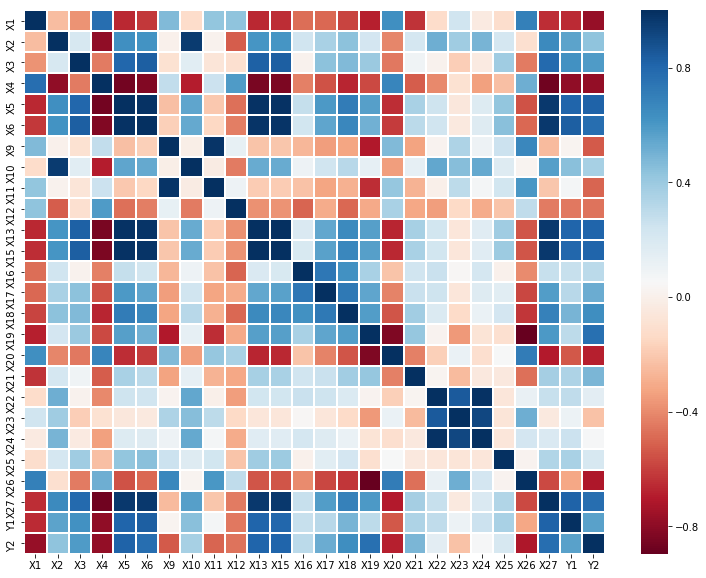

In [4]:
import pandas as pd ## 판다스 블러오기 ##
data=pd.read_csv("HW1.csv") ## 판다스에서 csv파일을 데이터프레임 타입으로 가져오기 ##
corr= data.corr(method='pearson') ## correlation 출력 함수 by Pandas ##
##print(corr) 
from matplotlib import pyplot as plt ## 그림그려주는 라이브러리1 matplotlib ##
import seaborn as sns  ## 그림 그려주는 라이브러리2 ##
plt.figure(figsize=(13,10)) ##출력할 그래프의 크기 ##
sns.heatmap(corr, fmt="g", linewidths=1, cmap='RdBu' ) ## Heatmap으로 표현하기 by Seaborn ##
plt.show() ##설정한 그래프 출력 ##